# Scrape News Data From Guardian

In [1]:
from selenium import webdriver
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support import expected_conditions
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.support.ui import Select

from bs4 import BeautifulSoup
import requests
import time
import datetime as dt 
import pandas as pd
import pickle
import os

In [ ]:
driver=webdriver.Edge()

driver.maximize_window()
driver.execute_script("document.body.style.zoom='50%'")

In [ ]:
try:
    close_cookies_button=driver.find_element(By.CSS_SELECTOR,'div[class="message-component message-row"] button[title="Yes, I’m happy"]')
    close_cookies_button.click()
except:
    None

###### Create Directories For Storing Scraped Files

In [ ]:
try:
    os.makedirs('csv_files/guardian/article_urls/',exist_ok=False)
except:
    None

try:
    os.makedirs('csv_files/guardian/article_data/',exist_ok=False)
except:
    None

In [ ]:
##### Scraping URLs and Storing For Later Scraping

In [ ]:
article_urls=[]

for page in range(1901,6000):
    page_url=f"https://www.theguardian.com/environment?page={page}"
    driver.get(page_url)

    try:
        close_button=driver.find_element(By.CSS_SELECTOR,'div[class="automat-1x8q7qo"] div[class="automat-1twt2zx"]')
        driver.execute_script("arguments[0].click();", close_button)
    except:
        None
    
    WebDriverWait(driver,10).until(expected_conditions.visibility_of_all_elements_located,((By.CSS_SELECTOR,'div[class="fc-container--rolled-up-hide fc-container__body"] div[class="fc-item__container"] a[class="u-faux-block-link__overlay js-headline-text"]')))
    articles=driver.find_elements(By.CSS_SELECTOR,'div[class="fc-container--rolled-up-hide fc-container__body"] div[class="fc-item__container"] a[class="u-faux-block-link__overlay js-headline-text"]')
    for article in articles:
        try:
            href=article.get_attribute('href')
            article_urls.append(href)
        except:
            None
    time.sleep(1)

    if page%100==0:
        pickle.dump(article_urls, open(f'csv_files/guardian/article_urls/article_urls_list_{page-100}-{page}.pickle','wb'))
        article_urls=[]

    print(f'Page {page}',end='\r')

In [ ]:
all_data=[]
for file in os.listdir('csv_files/guardian/article_urls/'):
    if file.endswith('.pickle'):
        data=pickle.load(open(os.path.join('csv_files/guardian/article_urls/',file),'rb'))
        all_data+=data

In [ ]:
all_article_urls=(set(all_data))
len(all_article_urls)

##### Scraping Article Data From Stored URLs

In [ ]:
data=[]

for i,article_url in enumerate(all_article_urls,start=1):
    try:
        html=requests.get(article_url).content
        soup=BeautifulSoup(html,'html')
    except:
        continue

    try:
        title=soup.select_one('div[data-gu-name="headline"]').text
    except:
        title=None        
    try:
        intro_text=soup.select_one('div[data-gu-name="standfirst"]').text
    except:
        intro_text=None        
    try:
        authors=soup.select_one('aside[data-gu-name="meta"]').get_text(separator='|')
    except:
        authors=None        
    try:
        article_text=soup.select_one('div[class="dcr-1b457fa"] div[id="maincontent"]').text
    except:
        article_text=None  

    data.append({'Title':title,'Intro Text':intro_text,'Authors':authors,'Article Text':article_text})
    
    if i%1000==0:
        pickle.dump(data,open(f'csv_files/guardian/article_data/article_data_list_{i-1000}-{i}.pickle','wb'))
        data=[]

    print(f'{i}/{len(all_article_urls)} articles scapred',end='\r')

# Cleaning Scraped Data And Saving As CSV File

In [ ]:
all_data=[]
for file in os.listdir('csv_files/guardian/article_data/'):
    if file.endswith('.pickle'):
        data=pickle.load(open(os.path.join('csv_files/guardian/article_data/',file),'rb'))
        all_data+=data

In [ ]:
df=pd.DataFrame(all_data).drop_duplicates().dropna(how='all')

In [ ]:
days_of_the_week=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

time=df['Authors'].apply(lambda x:x.split('|')[-1] if isinstance(x,str) else x)
time=time.apply(lambda x:x.replace('Last modified on','').strip() if isinstance(x,str) else x)
time=time.apply(lambda x: x.split(' ')[1]+' '+', '.join(x.split(' ')[2:-2]) if isinstance(x,str) else x)
time=time.apply(pd.to_datetime,errors='coerce')

df['Date Published']=time

In [ ]:
authors_list_1=df['Authors'].apply(lambda x:x.split('|')[:-1] if isinstance(x,str) else x)
authors_list_2=[]
for i in authors_list_1:
    if i and len(i)>=2:
        authors_list_2.append(i[:-1])
    else:
        authors_list_2.append(i)

authors_list_3=[]
for authors in authors_list_2:
    if authors and len(authors)==1 and (True in [d in authors[0] for d in days_of_the_week]):
        authors_list_3.append(None)
    else:
        authors_list_3.append(authors)

df['Authors']=authors_list_3

In [ ]:
replace_list=[
    'This article is more than 1 year old',
    'This article is more than 2 years old',
    'This article is more than 3 years old',
    'This article is more than 4 years old',
    'This article is more than 5 years old',
]

for i in replace_list:
    df['Title']=df['Title'].str.replace(i,'')

In [ ]:
#df.to_csv('csv_files/guardian/guardian_environment_news.csv',index=False)

# Visualizing Results

In [2]:
df=pd.read_csv('csv_files/guardian/guardian_environment_news.csv')

In [3]:
df

,Title,Intro Text,Authors,Article Text,Date Published
0,Liz Truss ‘will approve more oil drilling if ...,Tory leadership candidate criticised by campai...,"['Rob Davies', '@ByRobDavies']",Liz Truss will sign off on a push for more oil...,2022-08-30
1,Renewed Highland golf course plan has environm...,Scottish government rejected a new links at Co...,"['Ewan Murray', '@mrewanmurray']",It is an area so tranquil that the notion of b...,2021-03-22
2,Visiting green spaces deters mental health dr...,Positive effects were stronger among those rep...,"['Damien Gayle', '@damiengayle']","Visits to parks, community gardens and other u...",2023-01-17
3,Bought too much red cabbage? Turn it into a fe...,This fantastic vegan centrepiece makes full us...,['Tom Hunt'],"I devised today’s nut roast for Oddbox, a veg ...",2023-12-22
4,‘This year has been very good’: readers’ UK bu...,Readers share their favourite sightings over t...,['Guardian readers'],‘Constant companions to our gardening’A peacoc...,2023-12-19
...,...,...,...,...,...
30054,Climate change could make insurance too expen...,"Munich Re, world’s largest reinsurance firm, w...",['Arthur Neslen'],Insurers have warned that climate change could...,2021-08-25
30055,Republican lawmaker pitches carbon tax in def...,Representative Carlos Curbelo has proposed a t...,"['Oliver Milman', ' in New York', '@olliemilman']",A Republican lawmaker has proposed that the US...,2021-08-25
30056,MPs call for urgent investigation into $180m ...,Cross-party group asks auditor general to seek...,['Anne Davies'],A cross-party group of federal MPs has asked t...,2018-04-25
30057,NaN,Reports that a mass of ice is in danger of bre...,NaN,Like millions of their compatriots around the ...,2021-08-25


In [4]:
df['Date Published']=pd.to_datetime(df['Date Published'],errors='coerce')

In [5]:
df['Article Text']=df['Article Text'].str.replace('.','. ')

In [6]:
df.isna().mean()

Title             0.031538
Intro Text        0.002728
Authors           0.152034
Article Text      0.012243
Date Published    0.081207
dtype: float64

In [7]:
df.columns

Index(['Title', 'Intro Text', 'Authors', 'Article Text', 'Date Published'], dtype='object')

In [8]:
import nltk

tokenizer=nltk.RegexpTokenizer(r'\w+')
lemmatizer=nltk.stem.WordNetLemmatizer()
stopwords=nltk.corpus.stopwords.words('english')

from nltk.sentiment import SentimentIntensityAnalyzer
sia=SentimentIntensityAnalyzer()

In [9]:
def text_to_scores(text):
    tokenized=tokenizer.tokenize(text)
    tokens_lowered=[t.lower() for t in tokenized]
    lemmatized=[lemmatizer.lemmatize(t) for t in tokens_lowered]
    tokens=[t for t in lemmatized if t not in stopwords]
    text_again=' '.join(tokens)
    scores=sia.polarity_scores(text_again)
    return scores

In [ ]:
scores = []

for i,text in enumerate(df['Article Text']):
    if isinstance(text, str):
        scores.append(text_to_scores(text))
    else:
        scores.append(None)
    
    if i%1000==0:
        print(f'{i}/{len(df)}',end='\r')

In [10]:
#pickle.dump(scores,open('csv_files/guardian/sentiment_scores.pickle','wb'))
scores=pickle.load(open('csv_files/guardian/sentiment_scores.pickle','rb'))

In [11]:
scores=[i['compound'] if i else None for i in scores]

In [12]:
df['Sentiment Score']=scores

In [13]:
import plotly.express as px
import plotly.graph_objects as go

In [14]:
g=df.groupby(df['Date Published'].dt.to_period('M')).agg({'Title':'count','Sentiment Score':'mean'}).reset_index()
g['Date Published']=g['Date Published'].astype(str)

In [15]:

fig=px.bar(g,x='Date Published',y='Sentiment Score',color='Sentiment Score',color_continuous_scale='Greens')
fig.update_layout(yaxis2=dict(overlaying='y',side='right'))
trace_1=go.Scatter(x=g['Date Published'],y=g['Title'],yaxis='y2',mode='lines+markers',name='count')
fig.add_trace(trace=trace_1)

fig.update_traces(selector=dict(name='count'),marker=dict(size=g['Title']/100))
fig.update_layout(template='plotly_dark')
fig.update_layout(title=dict(text="Average Sentiment Scores Of Guardian's Articles By Period",font_family='Arial Black'))
fig.update_layout(coloraxis_showscale=False)
fig.update_xaxes(tickvals=g['Date Published'],tickfont_size=8,tickangle=45)

In [16]:
fig=px.histogram(df['Sentiment Score'],nbins=150,color_discrete_sequence=['green'])
fig.update_layout(template='plotly_dark')
fig.update_layout(title=dict(text='Frequency Distribution Of Sentiment Scores',font_family='Arial Black'))

### Plotting Most Used Words

In [ ]:
all_words=[]
for i,text in enumerate(df['Article Text']):
    try:
        tokenized=tokenizer.tokenize(text)
        tokens_lowered=[t.lower() for t in tokenized]
        lemmatized=[lemmatizer.lemmatize(t) for t in tokens_lowered]
        tokens=[t for t in lemmatized if t not in stopwords]
        for token in tokens:
            all_words.append(token)
    except:
        continue
    if i%100:
        print(f'{i}/{len(df)}',end='\r')

In [17]:
#pickle.dump(all_words,open('csv_files/guardian/all_words.pickle','wb'))

In [18]:
all_words=pickle.load(open('csv_files/guardian/all_words.pickle','rb'))

In [19]:
all_words_count={}
for word in all_words:
    if word not in all_words_count:
        all_words_count[word]=0
    else:
        all_words_count[word]+=1

all_words_count=dict(sorted(all_words_count.items(), key=lambda item: item[1],reverse=True))

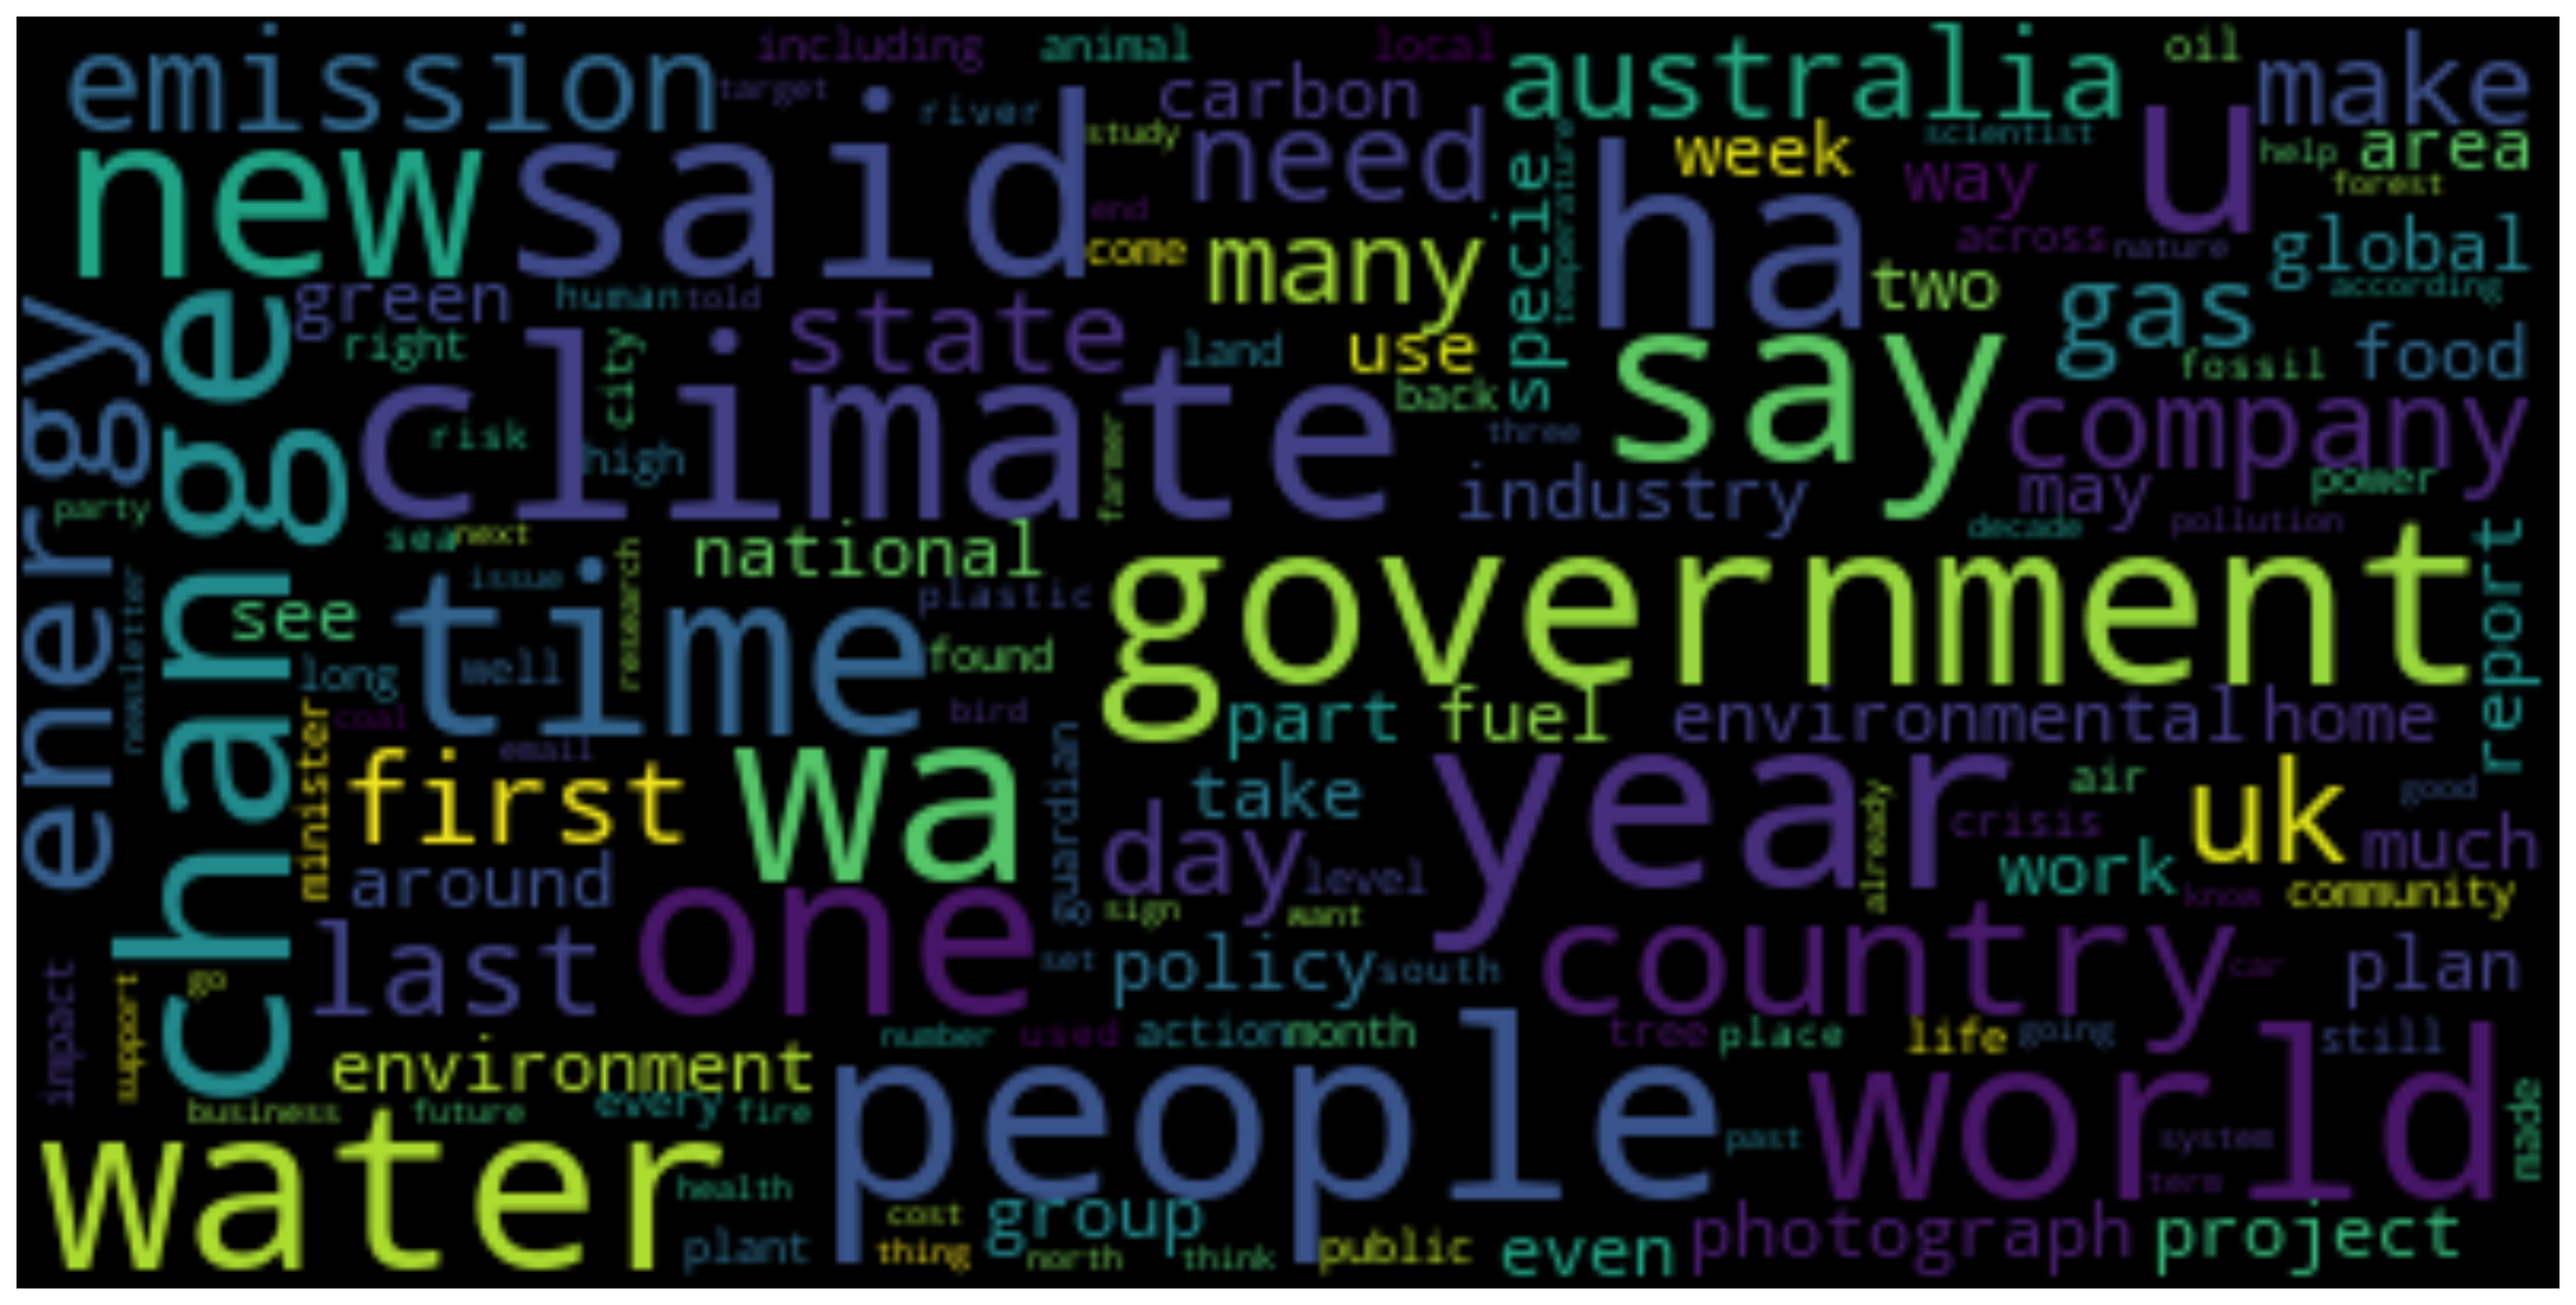

In [20]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.style.use('ggplot')


wordcloud = WordCloud(max_font_size=40).generate(" ".join([(k + ' ') for i,(k, v) in enumerate(all_words_count.items()) if i<=200]))

plt.figure(figsize=(20,10),dpi=200)
plt.imshow(wordcloud, interpolation="bilinear",cmap='Greens')
plt.axis("off")
plt.show()

In [21]:
#200 most common words used in the articles
{k:v for i,(k,v) in enumerate(all_words_count.items()) if i<=200}

{'said': 128361,
 'wa': 121314,
 'ha': 106550,
 'year': 82675,
 'climate': 82121,
 'would': 54799,
 'people': 54273,
 'government': 53829,
 'say': 52542,
 'new': 51286,
 'one': 50887,
 'water': 48116,
 'also': 43443,
 'change': 40137,
 'world': 38821,
 'u': 38758,
 'time': 37166,
 'could': 35694,
 'country': 33625,
 'energy': 33440,
 'emission': 31902,
 'uk': 30729,
 'company': 29171,
 'like': 29129,
 'need': 28347,
 'last': 27366,
 'australia': 26843,
 'many': 25929,
 'make': 25577,
 'day': 24900,
 'gas': 24764,
 'first': 24743,
 'state': 24358,
 'photograph': 23945,
 'global': 23907,
 'area': 23628,
 'carbon': 23550,
 'environmental': 23518,
 'policy': 23297,
 'two': 23133,
 'way': 22990,
 'environment': 22698,
 'use': 22563,
 'part': 21495,
 'get': 21108,
 '000': 21069,
 'industry': 20762,
 'may': 20715,
 'group': 20642,
 'plan': 20585,
 'much': 20335,
 'even': 20304,
 'food': 20279,
 'see': 20039,
 'work': 20032,
 'national': 19998,
 'project': 19996,
 'specie': 19857,
 'around': 1

In [22]:
#government, water, climate, change, energy, emission, uk, australia, gas, carbon, environment, food, crisis, oil,air, sea, plastic, pollution,south, north, coal,temperature, wildlife, forest, fire,

##### Finding Most Used Combination Of Two Words And Visualizing Their Usage Frequency

In [23]:
from nltk import ngrams
from collections import Counter

target_words = ['government', 'water', 'climate', 'change', 'energy', 'emission', 'uk', 'australia', 'gas', 
                'carbon', 'environment', 'food', 'crisis', 'oil', 'air', 'sea', 'plastic', 'pollution',
                'south', 'north', 'coal', 'temperature', 'wildlife', 'forest', 'fire']


def get_most_common_words(year):
    filtered_df=df[df['Date Published'].dt.year==year]
    article_texts = filtered_df['Article Text'].dropna()
    all_text = ' '.join(article_texts)

    words = all_text.split()
    words=[w for w in words if w not in stopwords]

    bigrams = ngrams(words, 2)
    filtered_bigrams = [bigram for bigram in bigrams if any(word in target_words for word in bigram)]

    filtered_bigram_counts = Counter(filtered_bigrams)
    filtered_bigram_df = pd.DataFrame(filtered_bigram_counts.items(), columns=['Bigram', 'Count'])

    to_replace=[',','.']
    for i in to_replace:
        filtered_bigram_df['Bigram'] = filtered_bigram_df['Bigram'].apply(lambda bigram: (bigram[0].replace(i, ''), bigram[1].replace(i, '')))
    filtered_bigram_df=filtered_bigram_df.groupby('Bigram')['Count'].sum().reset_index().sort_values('Count',ascending=False)
    top_filtered_bigram_df=filtered_bigram_df.head(20)

    texts=top_filtered_bigram_df['Bigram'].apply(lambda x:x[0]+' '+x[1])
    count_dict={}
    for text in texts:
        count_dict[text] = 0
        for article in filtered_df['Article Text'].dropna():
            if text in article:
                count_dict[text]+=1
    sorted_count_dict = dict(sorted(count_dict.items(), key=lambda item: item[1], reverse=True))
    percentage_dict={}
    for text, unique_count in sorted_count_dict.items():
        percentage_dict[text]=unique_count/len(filtered_df['Article Text'].dropna())
    
    return percentage_dict
   

In [24]:
years=list(sorted((df['Date Published'].dt.year).unique()))
years = [int(year) for year in years if not pd.isnull(year)]


all_dicts={}
for year in years:
    percentage_dict=get_most_common_words(year)
    all_dicts[year]=percentage_dict
    print(year,end='\r')

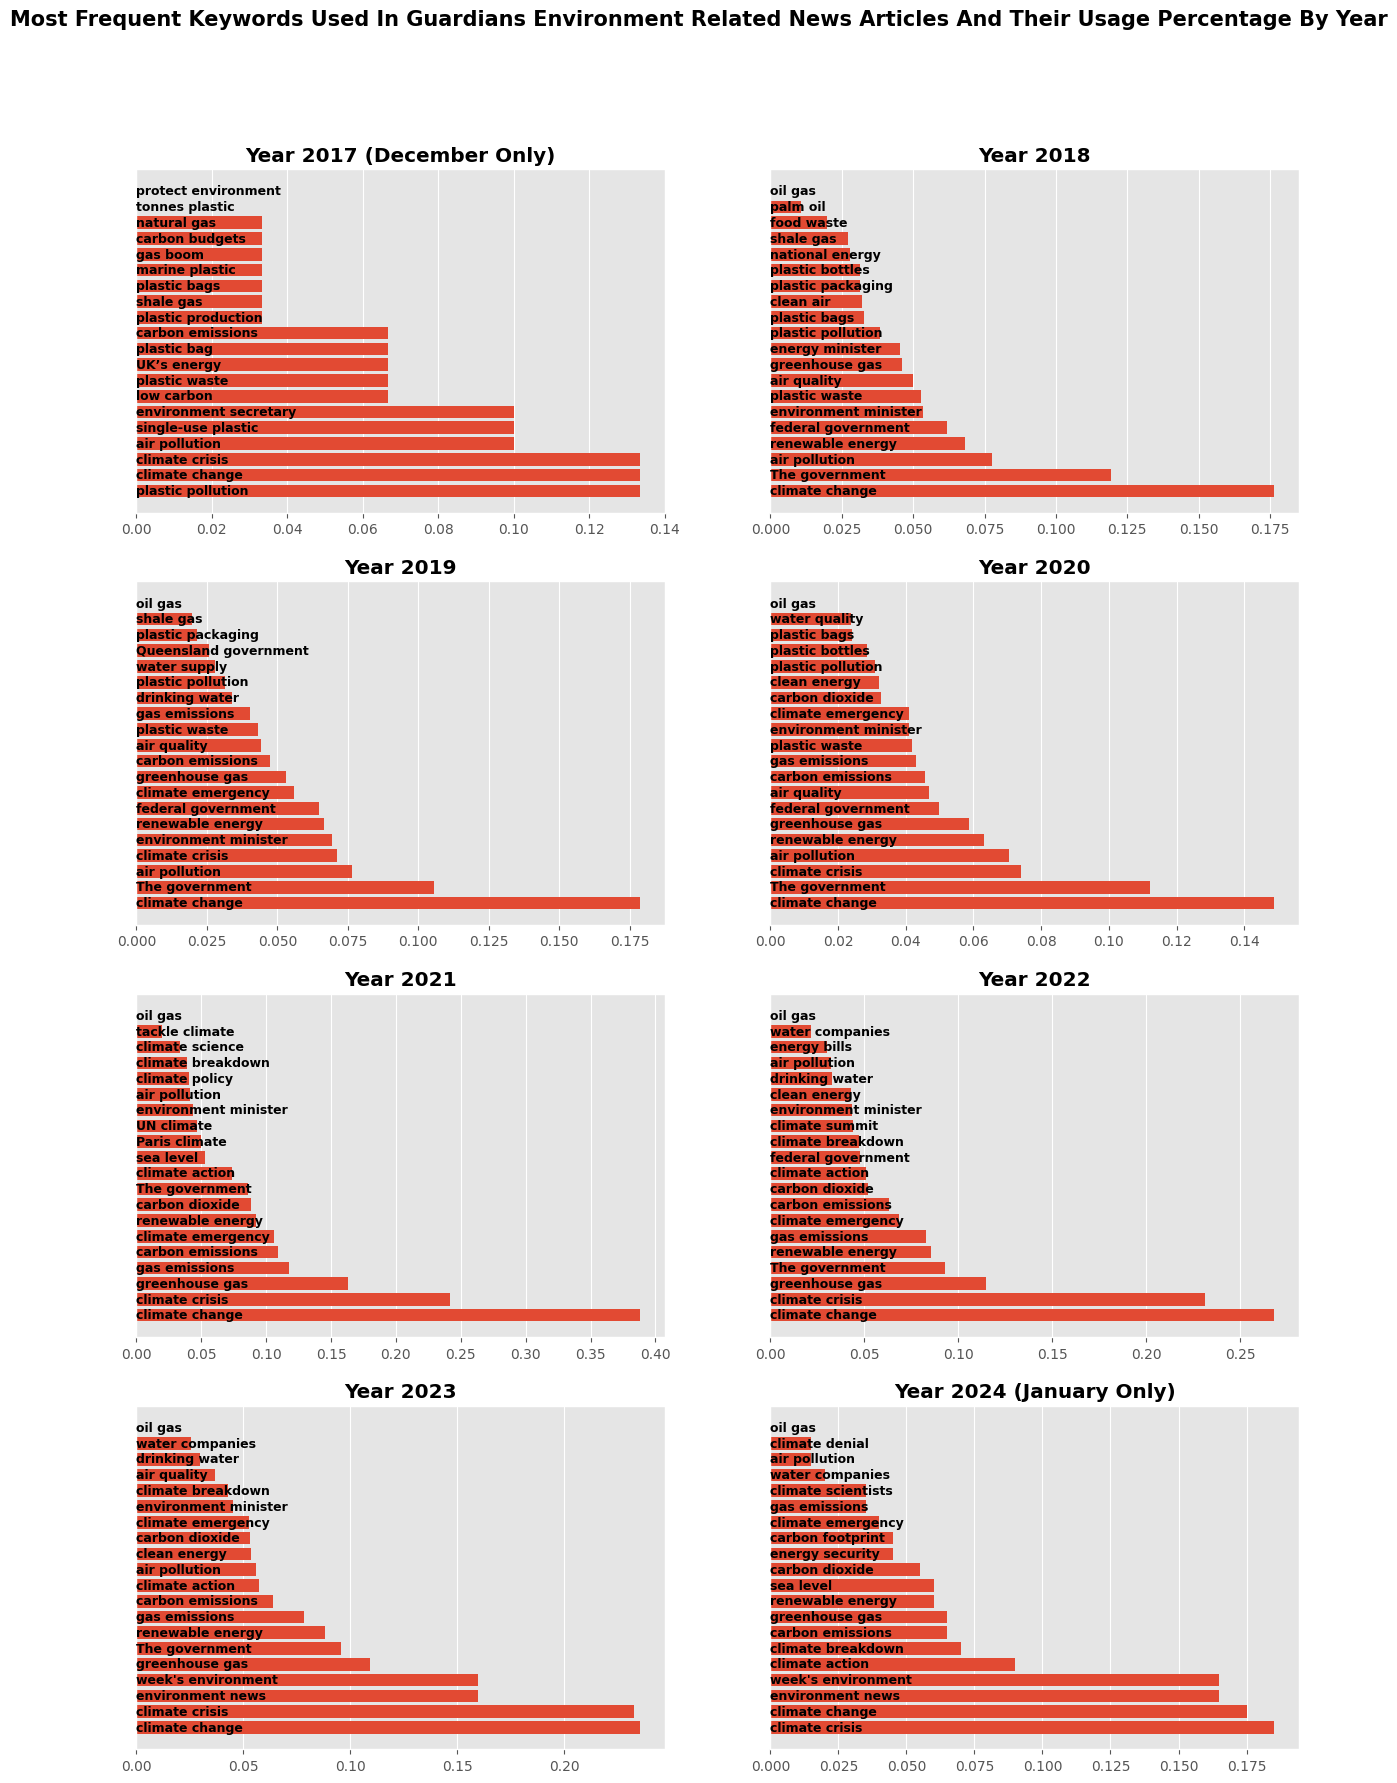

In [43]:
fig,axes=plt.subplots(4,2,figsize=(15,20),dpi=100)

for ax,(year,percentage_dict) in zip(axes.ravel(),all_dicts.items()):
    ax.barh(y=[k for k,v in percentage_dict.items()],width=[v for k,v in percentage_dict.items()])
    ax.set_yticks([])
    ax.set_title(f'Year {year} (December Only)',fontweight='bold') if year==2017 else ax.set_title(f'Year {year} (January Only)',fontweight='bold') if year==2024 else ax.set_title(f'Year {year}',fontweight='bold')
    for i in range(len(percentage_dict)):
        ax.text(y=[k for k,v in percentage_dict.items()][i],x=0,s=[k for k,v in percentage_dict.items()][i],fontweight='bold',va='center',size=9)

plt.subplots_adjust(top=0.9, hspace=0.2)
plt.suptitle('Most Frequent Keywords Used In Guardians Environment Related News Articles And Their Usage Percentage By Year', fontweight='bold',size=15)
plt.show()